# 🏞 Convolutional Neural Network

In this notebook, we'll walk through the steps required to train your own convolutional neural network (CNN) on the CIFAR dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
# import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

## 0. Parameters <a name="parameters"></a>

In [2]:
NUM_CLASSES = 10

## 1. Prepare the Data <a name="prepare"></a>

In [3]:
# Download CIFAR10 dataset.
trainset_tensor = datasets.CIFAR10(root = './data', train=True, download=True, transform=ToTensor())
testset_tensor = datasets.CIFAR10(root = './data', train=False, download=True, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Put into data loader.
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset_tensor, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_tensor, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [5]:
# Get tensors for use later.
x_train = trainset_tensor.data
y_train = trainset_tensor.targets
x_test = testset_tensor.data
y_test = testset_tensor.targets

In [6]:
# Normalize.
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# One hot encode.
y_train = np.eye(NUM_CLASSES, dtype='uint8')[y_train]
y_test = np.eye(NUM_CLASSES, dtype='uint8')[y_test]

## 2. Build the model <a name="build"></a>

In [15]:
# In tensorflow padding = 'same' can be used with a stride > 1. That is not the case in Pytorch.
# The models size will be a bit different in PyTorch in our case. 
c1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='same')
n1 = nn.BatchNorm2d(32)
r1 = nn.LeakyReLU()

c2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same')
n2 = nn.BatchNorm2d(32)
r2 = nn.LeakyReLU()

c3  = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same')
n3 = nn.BatchNorm2d(64)
r3 = nn.LeakyReLU()

c4= nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same')
n4 = nn.BatchNorm2d(64)
r4 = nn.LeakyReLU()

f1 = nn.Flatten()

# l1 = nn.Linear(4096, 128)
l1 = nn.Linear(65536, 128)
n5 = nn.BatchNorm1d(128)
r5 = nn.LeakyReLU()
d1 = nn.Dropout(p=0.5)

l2 = nn.Linear(128, NUM_CLASSES)
s1 = nn.Softmax()

model = nn.Sequential(
    c1,
    n1,
    r1,

    c2,
    n2,
    r2,

    c3,
    n3,
    r3,

    c4,
    n4,
    r4,

    f1,

    l1,
    n5,
    r5,
    d1,

    l2,
    s1,
)

summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─BatchNorm2d: 1-2                       64
├─LeakyReLU: 1-3                         --
├─Conv2d: 1-4                            9,248
├─BatchNorm2d: 1-5                       64
├─LeakyReLU: 1-6                         --
├─Conv2d: 1-7                            18,496
├─BatchNorm2d: 1-8                       128
├─LeakyReLU: 1-9                         --
├─Conv2d: 1-10                           36,928
├─BatchNorm2d: 1-11                      128
├─LeakyReLU: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           8,388,736
├─BatchNorm1d: 1-15                      256
├─LeakyReLU: 1-16                        --
├─Dropout: 1-17                          --
├─Linear: 1-18                           1,290
├─Softmax: 1-19                          --
Total params: 8,456,234
Trainable params: 8,456,234
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─BatchNorm2d: 1-2                       64
├─LeakyReLU: 1-3                         --
├─Conv2d: 1-4                            9,248
├─BatchNorm2d: 1-5                       64
├─LeakyReLU: 1-6                         --
├─Conv2d: 1-7                            18,496
├─BatchNorm2d: 1-8                       128
├─LeakyReLU: 1-9                         --
├─Conv2d: 1-10                           36,928
├─BatchNorm2d: 1-11                      128
├─LeakyReLU: 1-12                        --
├─Flatten: 1-13                          --
├─Linear: 1-14                           8,388,736
├─BatchNorm1d: 1-15                      256
├─LeakyReLU: 1-16                        --
├─Dropout: 1-17                          --
├─Linear: 1-18                           1,290
├─Softmax: 1-19                          --
Total params: 8,456,234
Trainable params: 8,456,234
Non-trainable params: 0

## 3. Train the model <a name="train"></a>

In [16]:
learning_rate=0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

torch.compile(model)
crossEntropyLoss = nn.CrossEntropyLoss()

In [126]:
#
# Training helper function
#

# The training loop is something we need to write ourserlves in pytorch. It is not an included method like with Keras in Tensorflow.
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device='cpu'):
    
    for epoch in range(epochs):

        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            # zero the parameter gradients
            optimizer.zero_grad()
            # get info from batch
            inputs, targets = batch
            # adjust for device (default is cpu)
            inputs = inputs.to(device)
            targets = targets.to(device)
            # feed forward
            output = model(inputs)
            # loss
            loss = loss_fn(output, targets)
            loss.backward()
            # backward
            optimizer.step()
            # update ongoing loss variable
            training_loss += loss.data.item()
        # trianing_loss /= len(train_iterator)
        training_loss /= len(train_loader)

        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item()
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Accuracy = {:.2f}'.format(epoch + 1, training_loss, valid_loss, num_correct / num_examples))

In [127]:
train(model, optimizer, crossEntropyLoss, trainloader, testloader, epochs=10)

/Users/steve/Documents/Dev/Books/gen_dl_foster_code__pytorch/gdl-pytorch/generative-deep-learning-pytorch/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/var/folders/69/ncrrlk1j7510dx967flbkwmc0000gn/T/ipykernel_66950/2664937913.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 1, Training Loss: 1.98, Validation Loss: 1.85, Accuracy = 0.63
Epoch: 2, Training Loss: 1.84, Validation Loss: 1.80, Accuracy = 0.68
Epoch: 3, Training Loss: 1.79, Validation Loss: 1.78, Accuracy = 0.69
Epoch: 4, Training Loss: 1.76, Validation Loss: 1.75, Accuracy = 0.72
Epoch: 5, Training Loss: 1.74, Validation Loss: 1.74, Accuracy = 0.72
Epoch: 6, Training Loss: 1.72, Validation Loss: 1.73, Accuracy = 0.73
Epoch: 7, Training Loss: 1.70, Validation Loss: 1.73, Accuracy = 0.74
Epoch: 8, Training Loss: 1.68, Validation Loss: 1.72, Accuracy = 0.74
Epoch: 9, Training Loss: 1.67, Validation Loss: 1.72, Accuracy = 0.75
Epoch: 10, Training Loss: 1.65, Validation Loss: 1.71, Accuracy = 0.75


In [134]:
# Optional. Save Model
torch.save(model.state_dict(), 'checkpoint/model_weights.pth')

In [17]:
# Optional. Load saved Model
model_dict = torch.load('checkpoint/model_weights.pth')
model.load_state_dict(model_dict)

<All keys matched successfully>

## 4. Evaluation <a name="evaluate"></a>

In [18]:
model.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=65536, out_features=128, bias=True)
  (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Le

In [19]:
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

x_test_tensor = torch.from_numpy(x_test)
x_test_tensor = x_test_tensor.to(torch.float)
x_test_tensor = x_test_tensor.permute(0, 3, 2, 1)

preds = model(x_test_tensor)
preds_single = CLASSES[torch.argmax(preds, axis=-1)]

y_test_tensor = torch.FloatTensor(y_test)
actual_single = CLASSES[y_test]

/Users/steve/Documents/Dev/Books/gen_dl_foster_code__pytorch/gdl-pytorch/generative-deep-learning-pytorch/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


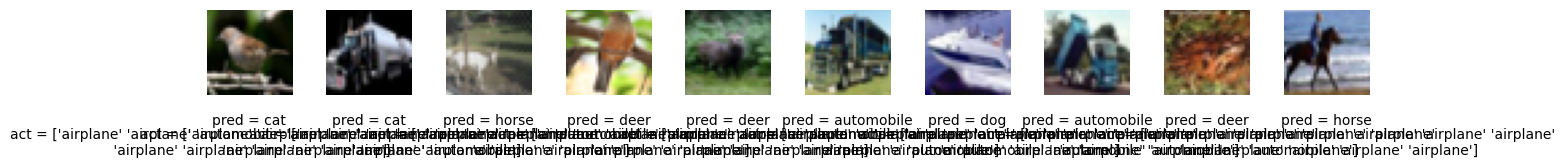

In [23]:
# Visualize the data.
# This perfoms not as well as we would like. We will improve it in the next nootbook.
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)